In [1]:
from brian2 import *

import random 
import time
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import pickle
from skimage.color import hsv2rgb

%load_ext autoreload
%autoreload 2

#Biblioteca de autoria propria
import neuronDynamics as nd

# Criar a rede neural biologica

In [11]:
arquivo = '../dados/swc/mid-neuron.swc'
tab = nd.read_swc(arquivo)

In [12]:
#ini = time.time()
%matplotlib inline

n = 50


seed = 45698 #seed 45698

ini = time.time()



df = nd.create_tab(tab, L=200, theta=-45)

random.seed(seed)
np.random.seed(seed)
img_teste, neurons_dict, img_color, colors = nd.create_net(df, n, 800)

final = time.time()
print(f'Tempo para execucao com {n} neuronios: {final-ini}')

plt.figure(figsize=(5, 5))
plt.imshow(img_color)

plt.show()

# SALVANDO NEURON_DICT EM UM ARQUIVO

#gravacao
neurons_dict_file = open(f'neurons_dict_{n}', 'wb') 
pickle.dump(neurons_dict, neurons_dict_file) 
neurons_dict_file.close()

KeyboardInterrupt: 

In [13]:
#leitura
neurons_dict_file = open('neurons_dict_50', 'rb')
neurons_dict = pickle.load(neurons_dict_file)

In [14]:
D = nd.create_D(neurons_dict) #Cria a matriz 2xN com os pixels que possuem conexao 
tree = KDTree(D) #Criacao da KD tree para obter os pares proximos com query_pairs()
pairs = tree.query_pairs(r=20, p=2)

edges = nd.create_edges(D, neurons_dict, pairs) #Cria as arestas do grafo



edges_raw = sorted(set(edges))
edges_raw_form = list(zip(*edges_raw))

vector_i_raw = edges_raw_form[0]
vector_j_raw = edges_raw_form[1]

print(edges_raw)


#len(edges_raw)

[(0, 17), (0, 21), (0, 28), (0, 45), (1, 2), (1, 8), (1, 10), (1, 15), (1, 17), (1, 18), (1, 19), (1, 35), (1, 39), (1, 41), (1, 46), (2, 1), (2, 8), (2, 12), (2, 14), (2, 15), (2, 17), (2, 18), (2, 35), (2, 36), (2, 39), (2, 41), (2, 44), (2, 45), (2, 46), (3, 5), (3, 7), (3, 16), (3, 20), (3, 25), (3, 26), (3, 32), (3, 37), (3, 47), (3, 48), (3, 49), (5, 2), (5, 3), (5, 7), (5, 14), (5, 16), (5, 18), (5, 20), (5, 25), (5, 26), (5, 30), (5, 37), (5, 48), (5, 49), (6, 38), (6, 43), (7, 3), (7, 5), (7, 16), (7, 20), (7, 25), (7, 37), (7, 48), (7, 49), (8, 1), (8, 2), (8, 15), (8, 17), (8, 35), (8, 39), (8, 41), (8, 46), (9, 23), (9, 40), (10, 18), (10, 19), (10, 35), (10, 40), (10, 44), (11, 3), (11, 32), (11, 47), (12, 1), (12, 2), (12, 8), (12, 15), (12, 17), (12, 36), (12, 41), (12, 45), (12, 46), (13, 2), (13, 10), (13, 14), (13, 18), (14, 2), (14, 18), (14, 20), (14, 44), (15, 1), (15, 2), (15, 4), (15, 8), (15, 12), (15, 17), (15, 21), (15, 28), (15, 35), (15, 36), (15, 39), (15, 

In [5]:
#REMOVENDO NEURONIOS

neurons_to_rm = []
tam_vaso = [400, 410]

# Encontrando quais neuronios devem ser removidos
for k,v in neurons_dict.items():
    if k[1] >= tam_vaso[0] and k[1] <= tam_vaso[1]:
        for i in v:
            neurons_to_rm.append(i[0])
            
# Eliminando duplicatas
neurons_to_rm = set(neurons_to_rm)
    
#print(neurons_to_rm)

# Encontrando o indice da tupla que contém o neuronio a ser removido da lista de arestas
to_remove = []
for i in range(len(edges_raw)):
    for indice in edges_raw[i]:
        if indice in neurons_to_rm:
            to_remove.append(edges_raw[i])
            
# Eliminando duplicatas
to_remove = list(set(to_remove))


edges_removed = edges_raw.copy() # Salvando a lista de arestas originais antes de fazer a remocao
# Removendo os neuronios
for tupla in to_remove:
    edges_removed.remove(tupla)

#Formatacao para usar na simulacao posteirormente
edges_removed_form = list(zip(*edges_removed))

vector_i_removed = edges_removed_form[0]
vector_j_removed = edges_removed_form[1]

print(neurons_to_rm)

{2, 8, 10, 12, 13, 14, 15, 17, 18, 19, 22, 24, 29, 31, 33, 39, 41, 42, 44}


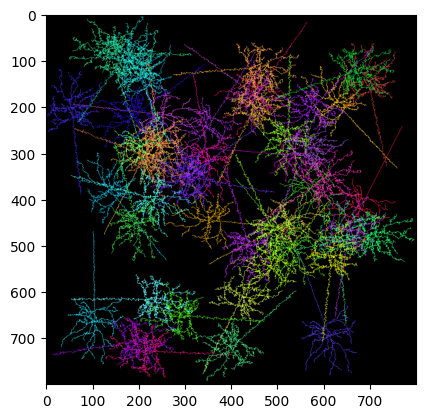

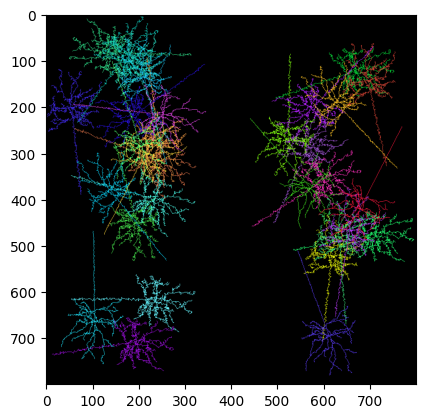

In [6]:
#Criacao da imagem apos a remocao de uma faixa de neuronios

for k,v in neurons_dict.items():
    v_temp = []
    for neuron, tipo in v:
        if neuron not in neurons_to_rm:
            v_temp.append((neuron, tipo))
    
    neurons_dict[k] = v_temp

neurons_dict_new = {}

for k,v in neurons_dict.items():
    if len(v) > 0:
        neurons_dict_new[k] = v
        
#neurons_dict = neurons_dict_new

img = np.zeros((800, 800, 3), dtype=np.uint8)

# Recuperando as cores originais da imagem
for k,v in neurons_dict_new.items():
    img[k[0], k[1]] = colors[v[0][0]]
    
img = hsv2rgb(img)


plt.imshow(img_color)
plt.figure()
plt.imshow(img, 'gray')

# Rede com os neuronios reais - SIMULACAO ANTES DA REMOCAO

In [89]:
# SORTEIO DE NEURONIOS ALEATORIOS PARA DISPARAREM TÔNICAMENTE DURANTE A SIMULAÇÃO

neurons_disp = []

for i in range(5):
    neuron = randint(0,n-1)
    while neuron in neurons_to_rm and neurons_disp:
        neuron = randint(0, n-1)
    neurons_disp.append(neuron)
    
print(neurons_disp)

[27, 48, 36, 7, 30]


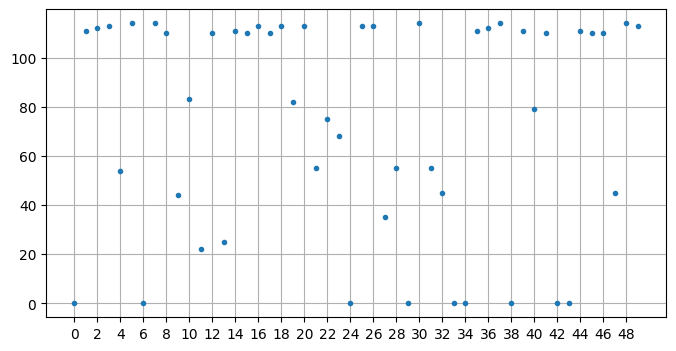

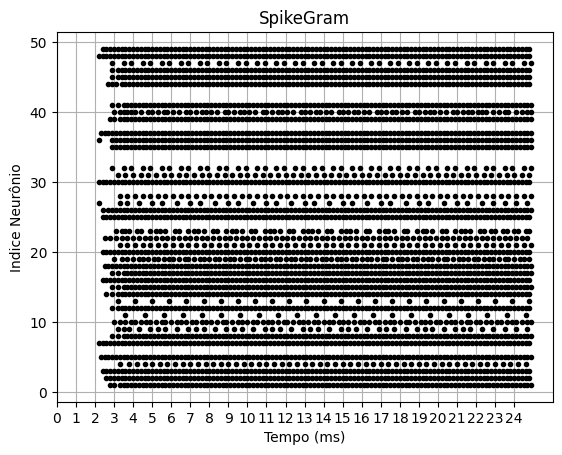

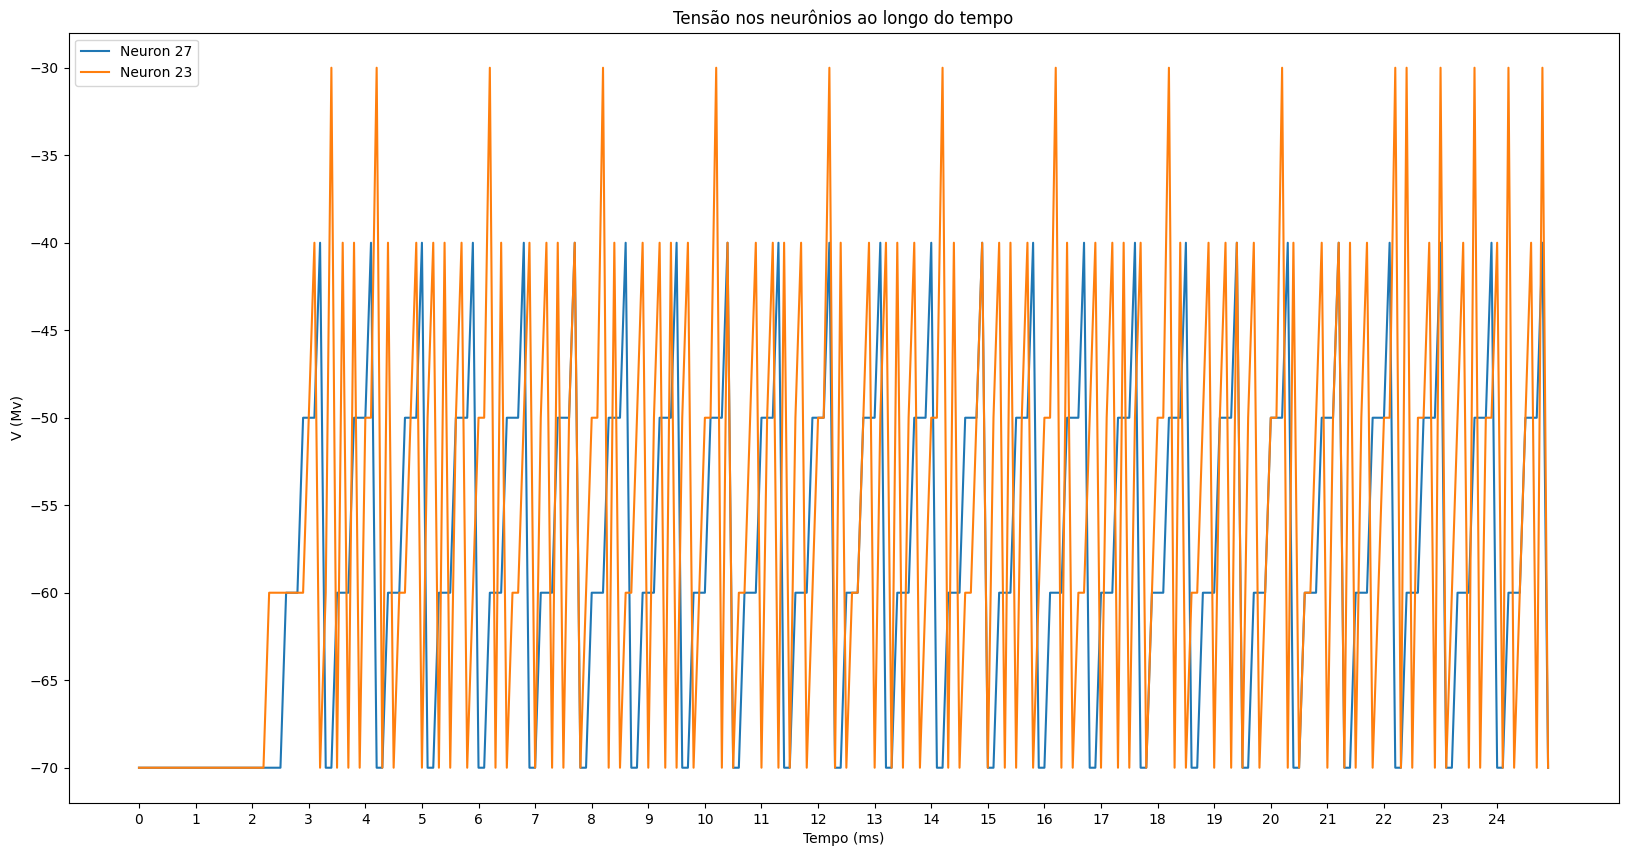

In [16]:
#print(edges_0)
n = 50
start_scope()
El = -70*mV

eqs = '''
dv/dt = ((El - v) + V)/tau : volt
V : volt
tau : second
'''

neurons_disp = [27, 48, 36, 7, 30]

G = NeuronGroup(n, eqs, threshold='v>-0.05*volt', reset='v = -0.07*volt', method='exact')
#G.V = [2, 0, 0, 0, 0, 0, 0, 0, 0, 0]*volt
G.V = ([0]*n)*volt
for neuron in neurons_disp:
    G.V[neuron] = 0.1*volt

G.v = ([-0.07]*n)*volt

G.tau = ([100*n])*ms
for neuron in neurons_disp:
    G.tau[neuron] = 10*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.01*volt')
S.connect(i=vector_i_raw, j=vector_j_raw)

M = StateMonitor(G, 'v', record=True)
PR = PopulationRateMonitor(G)
SM = SpikeMonitor(G)


run(25*ms) # Roda a simulacao

count_each = SM.count # Numero de spikes de cada neuronio
num_spikes = SM.num_spikes #Numero total de spikes


plt.figure(figsize=(8, 4))

#plot de spikes por neuronio
plt.plot(count_each, '.')
xticks(np.arange(0, 50, step=2))
plt.grid()


#Spike Gram
plt.figure()
plt.title('SpikeGram')
plt.plot(SM.t/ms, SM.i, '.k') 
xticks(np.arange(0, 25, step=1))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.grid()

# Frequencia de disparo de cada neuronio
#plot(PR.t/ms, PR.rate/Hz)




# Evolucao da tensao nos neuronios
plt.figure(figsize=(20, 10))
plt.title('Tensão nos neurônios ao longo do tempo')

plt.plot(M.t/ms, M.v[13]/mV, label='Neuron 27')
plt.plot(M.t/ms, M.v[23]/mV, label='Neuron 23')
#plt.plot(M.t/ms, M.v[48]/mV, label='Neuron 48')
#plt.plot(M.t/ms, M.v[26]/mV, label='Neuron 26')
#plt.plot(M.t/ms, M.v[3]/mV, label='Neuron 3')
#plt.plot(M.t/ms, M.v[5], label='Neuron 5')
#plt.plot(M.t/ms, M.v[6], label='Neuron 6')
#plt.plot(M.t/ms, M.v[7], label='Neuron 7')
#plt.plot(M.t/ms, M.v[8], label='Neuron 8')
#plt.plot(M.t/ms, M.v[9], label='Neuron 9')


xticks(np.arange(0, 25, step=1))
plt.xlabel('Tempo (ms)')
plt.ylabel('V (Mv)')
plt.legend()


plt.show()

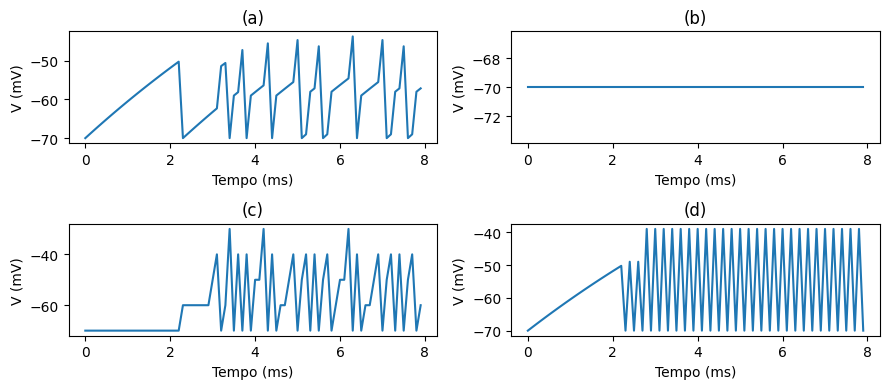

In [48]:
plt.figure(figsize=(9, 4))


plt.subplot(2,2,1)
plt.plot(M.t[0:80]/ms, M.v[27][0:80]/mV)
plt.title('(a)')
plt.xlabel('Tempo (ms)')
plt.ylabel('V (mV)')
plt.subplot(2,2,2)
plt.plot(M.t[0:80]/ms, M.v[33][0:80]/mV)
plt.title('(b)')
plt.xlabel('Tempo (ms)')
plt.ylabel('V (mV)')
plt.subplot(2,2,3)
plt.plot(M.t[0:80]/ms, M.v[23][0:80]/mV)
plt.title('(c)')
plt.xlabel('Tempo (ms)')
plt.ylabel('V (mV)')
plt.subplot(2,2,4)
plt.plot(M.t[0:80]/ms, M.v[48][0:80]/mV)
plt.title('(d)')
plt.xlabel('Tempo (ms)')
plt.ylabel('V (mV)')
plt.tight_layout()

# Rede com os neuronios reais - SIMULACAO APOS REMOCAO

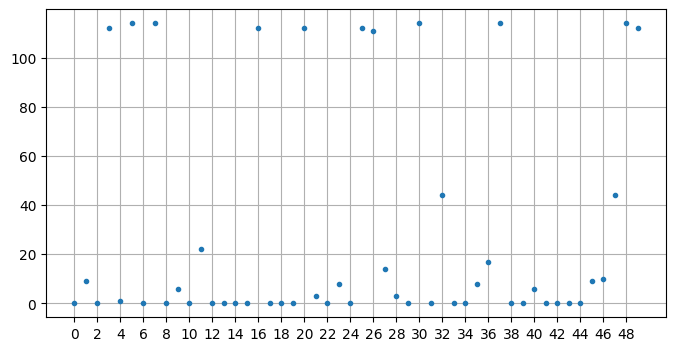

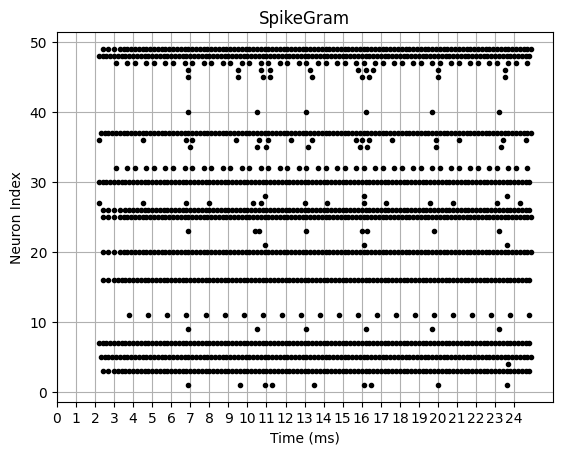

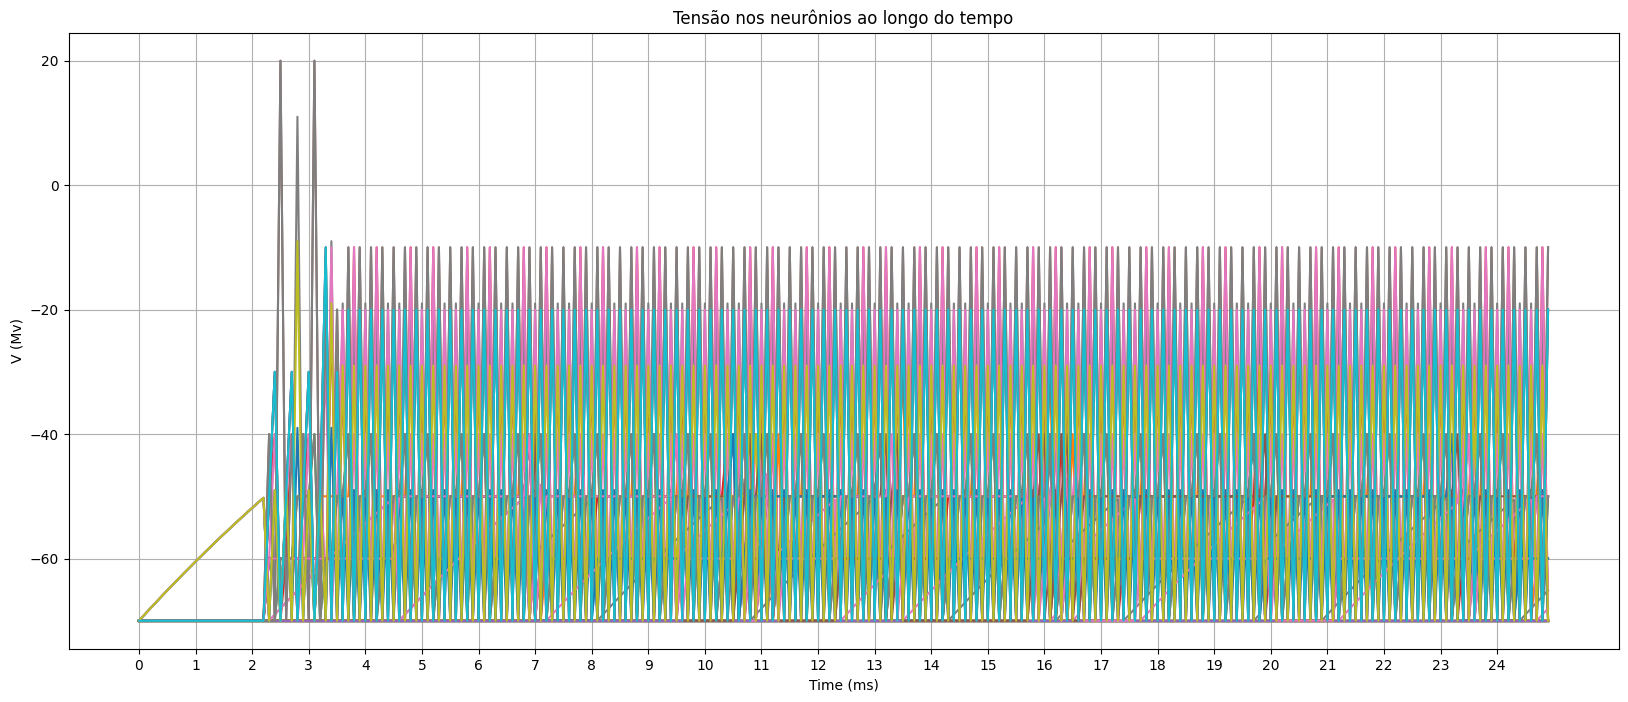

In [49]:
#print(edges_0)
start_scope()
El = -70*mV

eqs = '''
dv/dt = ((El - v) + V)/tau : volt
V : volt
tau : second
'''

neurons_disp = [27, 48, 36, 7, 30]

G = NeuronGroup(n, eqs, threshold='v>-0.05*volt', reset='v = -0.07*volt', method='exact')
#G.V = [2, 0, 0, 0, 0, 0, 0, 0, 0, 0]*volt
G.V = ([0]*n)*volt
for neuron in neurons_disp:
    G.V[neuron] = 0.1*volt

G.v = ([-0.07]*n)*volt

G.tau = ([100*n])*ms
for neuron in neurons_disp:
    G.tau[neuron] = 10*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.01*volt')
S.connect(i=vector_i_removed, j=vector_j_removed)

M = StateMonitor(G, 'v', record=True)
PR = PopulationRateMonitor(G)
SM = SpikeMonitor(G)


run(25*ms) # Roda a simulacao

count_each = SM.count # Numero de spikes de cada neuronio
num_spikes = SM.num_spikes #Numero total de spikes


#plot de spikes por neuronio
plt.figure(figsize=(8, 4))
plt.plot(count_each, '.')
xticks(np.arange(0, 50, step=2))
plt.grid()


plt.figure()
#Spike Gram
plt.title('SpikeGram')
plt.plot(SM.t/ms, SM.i, '.k') 


xticks(np.arange(0, 25, step=1))
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.grid()

# Frequencia de disparo de cada neuronio
#plot(PR.t/ms, PR.rate/Hz)




# Evolucao da tensao nos neuronios
plt.figure(figsize=(20, 8))
plt.title('Tensão nos neurônios ao longo do tempo')

for i in range(len(M.v)):
        plt.plot(M.t/ms, M.v[i]/mV, label=f'Neuron {i}')
    
#plt.plot(M.t/ms, M.v[0]/mV, label='Neuron 0')
#plt.plot(M.t/ms, M.v[1]/mV, label='Neuron 1')
#plt.plot(M.t/ms, M.v[2]/mV, label='Neuron 2')
#plt.plot(M.t/ms, M.v[3]/mV, label='Neuron 3')
#plt.plot(M.t/ms, M.v[4]/mV, label='Neuron 4')
#plt.plot(M.t/ms, M.v[5], label='Neuron 5')
#plt.plot(M.t/ms, M.v[6], label='Neuron 6')
#plt.plot(M.t/ms, M.v[7], label='Neuron 7')
#plt.plot(M.t/ms, M.v[8], label='Neuron 8')
#plt.plot(M.t/ms, M.v[9], label='Neuron 9')


xticks(np.arange(0, 25, step=1))
plt.xlabel('Time (ms)')
plt.ylabel('V (Mv)')
#plt.legend()
plt.grid()

plt.show()

In [40]:
print(SM.i)

<spikemonitor.i: array([ 0,  8, 24, ..., 41, 46, 47])>


# Teste de Spike

Text(0, 0.5, 'v')

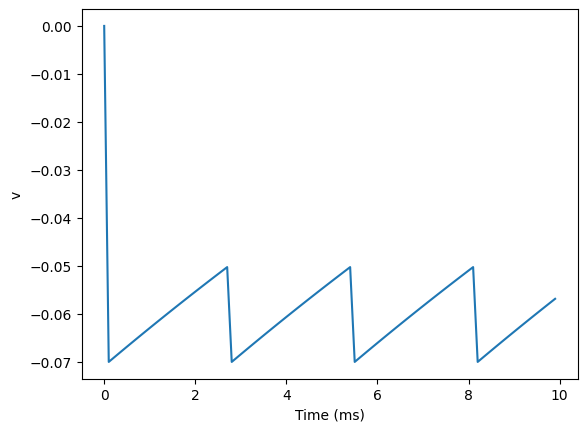

In [45]:


start_scope()

I = 200*mamp
R = 1*ohm
#tau = 25*ms
El = -70*mV
w = 1*mV


eq = Equations('''dv/dt = ((El - v) + R*I)/tau : volt
                 w : volt
               ''')


G_1 = NeuronGroup(10, eq, threshold='v > -50*mV', reset='v = -70*mV', method='exact')

M = StateMonitor(G_1, 'v', record=True)

run(10*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v')

# Rede com 6 neuronios em fila

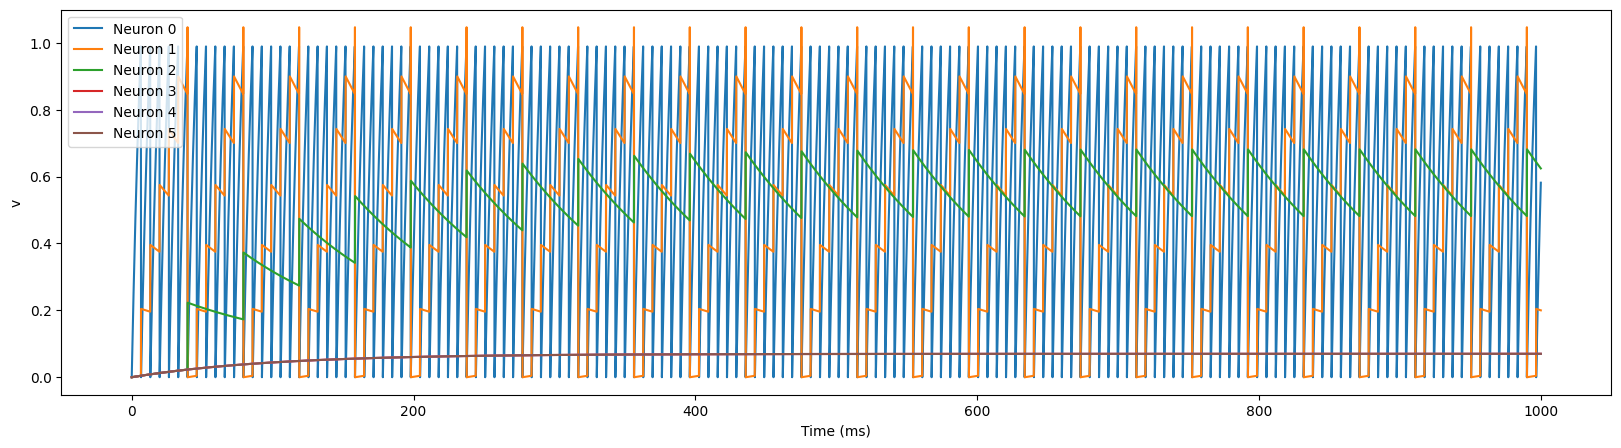

In [18]:
start_scope()
El = 0.07

eqs = '''
dv/dt = ((El - v) + V)/tau : 1
V : 1
tau : second
'''

G = NeuronGroup(6, eqs, threshold='v>1', reset='v = 0', method='exact')
G.V = [2, 0, 0, 0, 0, 0]
G.tau = [10, 100, 100, 100, 100, 100]*ms

# Comment these two lines out to see what happens without Synapses
S = Synapses(G, G, on_pre='v_post += 0.2')
S.connect(i=[0, 1, 2, 3, 4], j=[1, 2, 3, 4, 5])

M = StateMonitor(G, 'v', record=True)

run(1000*ms)

plt.figure(figsize=(20, 5))

plt.plot(M.t/ms, M.v[0], label='Neuron 0')
plt.plot(M.t/ms, M.v[1], label='Neuron 1')
plt.plot(M.t/ms, M.v[2], label='Neuron 2')
plt.plot(M.t/ms, M.v[3], label='Neuron 3')
plt.plot(M.t/ms, M.v[4], label='Neuron 4')
plt.plot(M.t/ms, M.v[5], label='Neuron 5')
plt.xlabel('Time (ms)')
plt.ylabel('v')
plt.legend();

# OUTROS

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


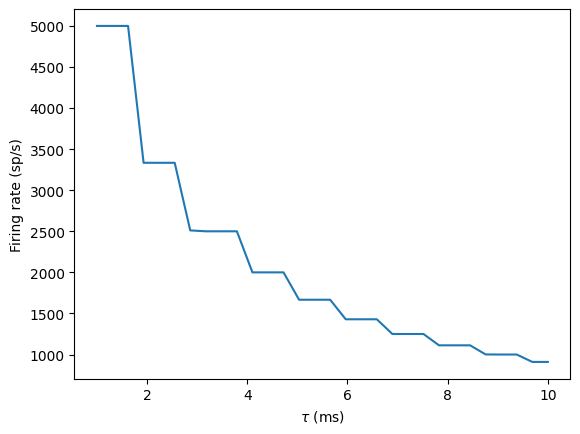

In [4]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1*mV
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)

tau = 25*ms; El = -70*mV
eqs = '''dv/dt = ((El - v) + R*I)/tau : volt
         I = 200*mamp : amp
         R = 1*ohm : ohm
         '''

G = NeuronGroup(1, eqs, threshold='v > -50*mV', reset='v = -70*mV', method='exact')
S = Synapses(P, G, on_pre='v += weight')

S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

0
0
0
0
0
0
0
0
1
0
0
1
2
3
4
6
6
15
13
20
18
23
28
30
34
33
41
43
41
48


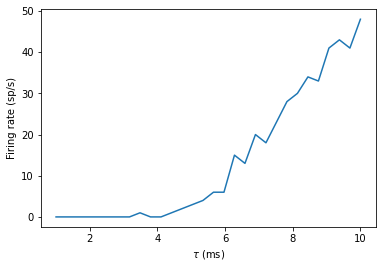

In [29]:
start_scope()
num_inputs = 100
input_rate = 10*Hz
weight = 0.1
tau_range = linspace(1, 10, 30)*ms
output_rates = []
# Construct the network just once
P = PoissonGroup(num_inputs, rates=input_rate)
eqs = '''
dv/dt = -v/tau : 1
'''
G = NeuronGroup(1, eqs, threshold='v>1', reset='v=0', method='exact')
S = Synapses(P, G, on_pre='v += weight')
S.connect()
M = SpikeMonitor(G)
# Store the current state of the network
store()
for tau in tau_range:
    # Restore the original state of the network
    restore()
    # Run it with the new value of tau
    run(1*second)
    output_rates.append(M.num_spikes/second)
    print(M.num_spikes)
plot(tau_range/ms, output_rates)
xlabel(r'$\tau$ (ms)')
ylabel('Firing rate (sp/s)');

In [30]:
tau_range

array([ 1.        ,  1.31034483,  1.62068966,  1.93103448,  2.24137931,
        2.55172414,  2.86206897,  3.17241379,  3.48275862,  3.79310345,
        4.10344828,  4.4137931 ,  4.72413793,  5.03448276,  5.34482759,
        5.65517241,  5.96551724,  6.27586207,  6.5862069 ,  6.89655172,
        7.20689655,  7.51724138,  7.82758621,  8.13793103,  8.44827586,
        8.75862069,  9.06896552,  9.37931034,  9.68965517, 10.        ]) * msecond

In [28]:
M.num_spikes/second

1. * hertz

In [20]:
P = PoissonGroup(10, rates=input_rate)
MP = SpikeMonitor(P)
# We use a Network object because later on we don't
# want to include these objects
net = Network(P, MP)
net.run(1*second)
# And keep a copy of those spikes
spikes_i = MP.i
spikes_t = MP.t
# Now construct the network that we run each time
# SpikeGeneratorGroup gets the spikes that we created before
SGG = SpikeGeneratorGroup(num_inputs, spikes_i, spikes_t)


In [26]:
print(spikes_i, spikes_t/ms)

<spikemonitor_2.i: array([8, 2, 9, 1, 9, 4, 1, 3, 8, 7, 0, 1, 3, 3, 9, 7, 5, 2, 5, 2, 7, 9,
       5, 5, 4, 9, 1, 1, 8, 7, 6, 9, 1, 6, 6, 4, 3, 4, 8, 1, 8, 3, 1, 5,
       1, 4, 4, 8, 6, 5, 8, 5, 1, 0, 3, 6, 9, 2, 7, 1, 0, 6, 4, 8, 2, 3,
       8, 5, 5, 7, 7, 9, 6, 3, 7, 3, 1, 3, 9, 8, 6, 1, 3, 4, 6, 9, 4, 5,
       6, 6, 4, 9, 3, 7, 4, 1, 7, 8, 4, 5, 7, 9, 3, 7, 3])> [  4.6   7.4  10.3  10.7  24.2  43.8  49.8  55.8  85.2  97.5 103.9 106.3
 110.7 111.5 115.5 116.1 117.6 121.  134.  154.  154.5 158.2 179.8 185.
 198.9 201.2 242.2 267.2 274.1 289.8 305.1 312.8 317.9 324.6 361.3 369.6
 376.5 387.4 390.8 398.8 406.5 416.8 419.4 420.6 426.1 427.9 428.6 436.5
 437.9 450.8 454.  483.6 485.  516.5 517.8 523.9 528.4 556.4 590.1 601.4
 612.  617.  626.3 636.2 636.9 637.1 642.1 653.3 657.4 675.6 688.1 690.5
 700.  704.6 712.4 720.4 728.8 729.6 737.7 740.  754.1 758.6 763.2 772.6
 782.8 812.1 853.8 867.4 877.2 886.6 896.5 896.7 906.5 906.8 907.5 910.3
 923.8 931.6 943.  949.5 952.8 959.4 960.1 968